In [403]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# IMPORTING LIBRARIES

# General Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

# Modeling part

import time

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cap-4611-spring-21-assignment-1/sample_submission.csv
/kaggle/input/cap-4611-spring-21-assignment-1/train.csv
/kaggle/input/cap-4611-spring-21-assignment-1/test.csv


In [404]:
# IMPORTING DATA
bank_data = pd.read_csv('../input/cap-4611-spring-21-assignment-1/train.csv')
sample_data = pd.read_csv('../input/cap-4611-spring-21-assignment-1/sample_submission.csv')
test_data = pd.read_csv('../input/cap-4611-spring-21-assignment-1/test.csv')
bank_data.head()

,id,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,0,0,0.647346,0.683820,0.667273,0.610069,0.610069,0.999181,0.797708,0.809538,...,0.845906,0.001164,0.624779,0.610068,0.843976,0.279420,0.026798,0.565193,1,0.030658
1,1,0,0.495247,0.555768,0.544997,0.600600,0.600600,0.999018,0.797449,0.809356,...,0.805535,0.006289,0.622790,0.600600,0.840984,0.282245,0.027232,0.566643,1,0.023030
2,2,0,0.493248,0.544865,0.544890,0.605810,0.605810,0.999011,0.797454,0.809376,...,0.803692,0.002246,0.624613,0.605807,0.840458,0.275849,0.026794,0.565171,1,0.093123
3,3,0,0.315117,0.364261,0.352910,0.619366,0.619366,0.997875,0.795752,0.807775,...,0.713786,0.000459,0.623901,0.619363,0.835870,0.275382,0.026774,0.565073,1,0.148308
4,4,0,0.526642,0.590547,0.578350,0.612866,0.612866,0.999036,0.797590,0.809484,...,0.826240,0.000556,0.624134,0.612867,0.841919,0.277004,0.026791,0.565158,1,0.051906


Now that we have an idea of our data, we need to obtain more information possible on them. The first thing that we want to understand is the nature of our data, namely if the data are numerical or categorical and if we have missing information among them. It is possible to check both these points using the .info() pandas method.

In [405]:
#GET DATA INFO
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 97 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   id                                                                   3410 non-null   int64  
 1   Bankrupt                                                             3410 non-null   int64  
 2    ROA(C) before interest and depreciation before interest             3410 non-null   float64
 3    ROA(A) before interest and % after tax                              3410 non-null   float64
 4    ROA(B) before interest and depreciation after tax                   3410 non-null   float64
 5    operating gross margin                                              3410 non-null   float64
 6    realized sales gross margin                                         3410 non-null   float64
 7    opera

In [406]:
# Checking Nan presence
[print(col) for col in bank_data if bank_data[col].isna().sum() > 0]

[]

The resulting panel is strongly informative for us, and it shows how:

The dataset is composed of a combination of 6819 observations per each of our 96 features.
All of the features are numerical (int64 or float64)
There are no missing values (Nan) among the data
Considering that all our features are numeric, we can easily calculate their descriptive statistics: a futher source of information.

In [407]:
# Computing the descriptive statistics of our numrerical features

bank_data.describe()

,id,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
count,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,...,3410.000000,3.410000e+03,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,3410.000000,3410.0,3410.000000
mean,1704.500000,0.032258,0.504990,0.558198,0.553204,0.607671,0.607646,0.998557,0.796919,0.808804,...,0.807647,3.439883e+07,0.623762,0.607669,0.840561,0.280355,0.027524,0.565098,1.0,0.047660
std,984.526536,0.176711,0.061003,0.065191,0.062121,0.018695,0.018674,0.018363,0.017781,0.018867,...,0.039163,5.154247e+08,0.013816,0.018695,0.009323,0.014021,0.012763,0.012213,0.0,0.050870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.224792,1.015558e-04,0.000000,0.000000,0.442176,0.182790,0.000789,0.172065,1.0,0.000000
25%,852.250000,0.000000,0.477526,0.535938,0.527973,0.600637,0.600630,0.998970,0.797386,0.809312,...,0.796842,8.836795e-04,0.623634,0.600635,0.840120,0.276987,0.026791,0.565158,1.0,0.024421
50%,1704.500000,0.000000,0.502559,0.559965,0.552091,0.605976,0.605933,0.999023,0.797461,0.809373,...,0.810659,2.101782e-03,0.623874,0.605975,0.841152,0.278809,0.026810,0.565256,1.0,0.033648
75%,2556.750000,0.000000,0.536282,0.589621,0.584694,0.613673,0.613620,0.999097,0.797578,0.809467,...,0.826620,5.401511e-03,0.624165,0.613671,0.842361,0.281485,0.026915,0.565729,1.0,0.052117
max,3409.000000,1.000000,1.000000,0.947067,0.957760,0.665151,0.665151,0.999778,0.809513,0.821053,...,0.944328,9.820000e+09,0.956387,0.665149,1.000000,1.000000,0.540672,0.735958,1.0,0.920638


Despite the fact that we already know that there are no missing values (here it's pretty easy considering that we have just 96 features) it is important to computationally check that this is true, to avoid errors and time wasted in the following steps of the project.

A further consideration needs to be done on the possibility to have duplicates in our data. Duplicates are identical observations that can create redundancy in our data and need to be dropped. Let's check the presence of duplicates to remove:

In [408]:
bank_data.duplicated().sum()

0

Considering the project task, and now that we have a general overview of our data, we need focus our attention on the labels: which are the financially stable and unstable companies? Let's take a look:

In [409]:
# The classes are heavily skewed we need to solve this issue later.

print(bank_data['Bankrupt'].value_counts())
print('-'* 30)
print('Financially stable: ', round(bank_data['Bankrupt'].value_counts()[0]/len(bank_data) * 100,2), '% of the dataset')
print('Financially unstable: ', round(bank_data['Bankrupt'].value_counts()[1]/len(bank_data) * 100,2), '% of the dataset')

0    3300
1     110
Name: Bankrupt, dtype: int64
------------------------------
Financially stable:  96.77 % of the dataset
Financially unstable:  3.23 % of the dataset


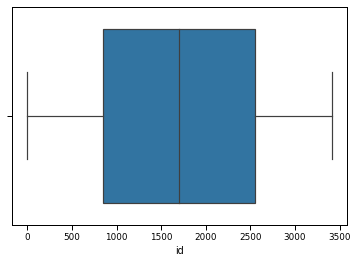

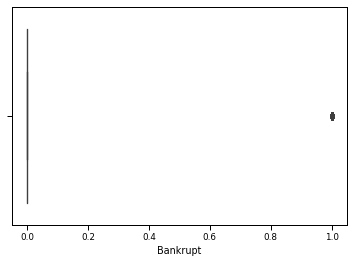

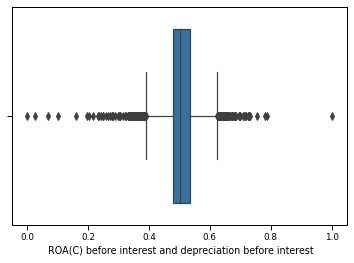

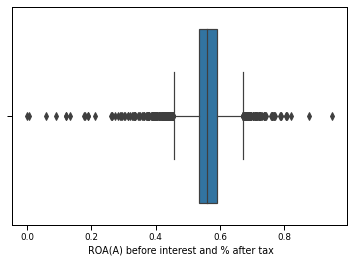

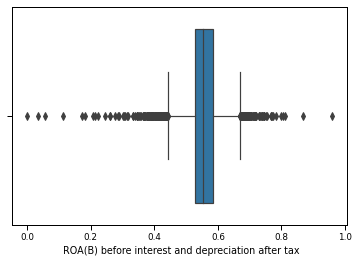

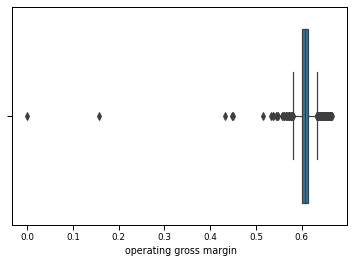

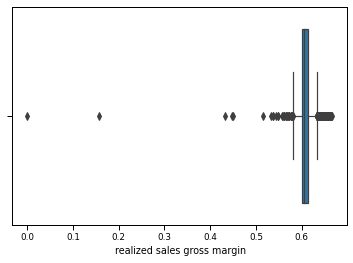

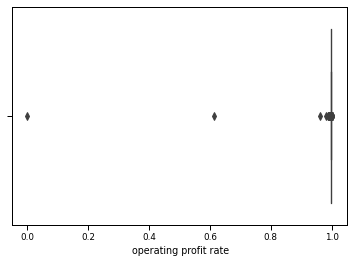

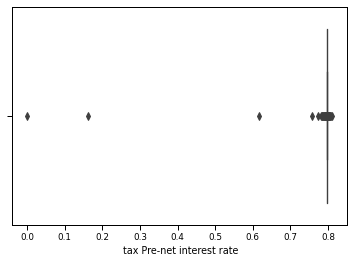

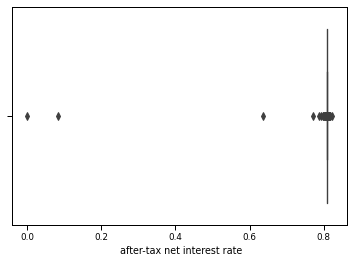

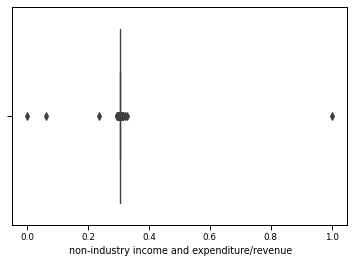

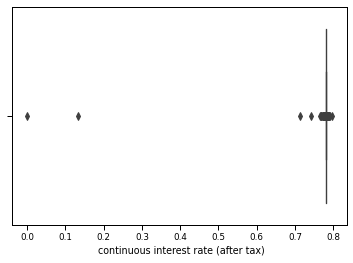

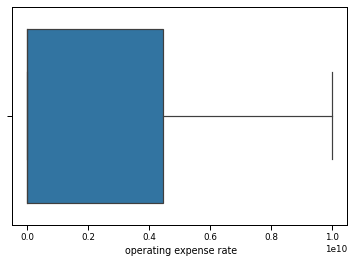

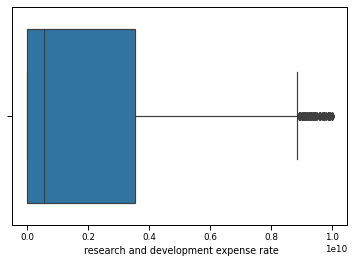

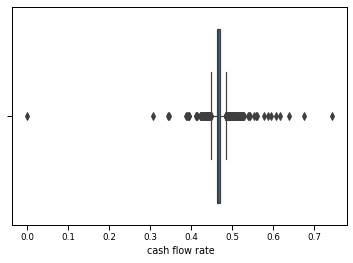

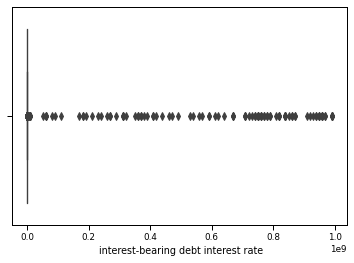

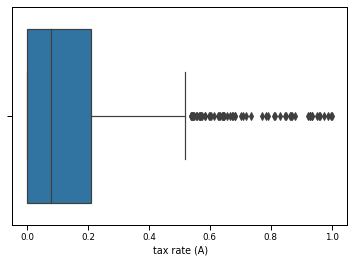

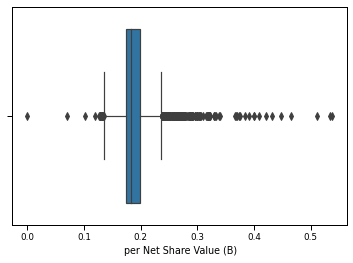

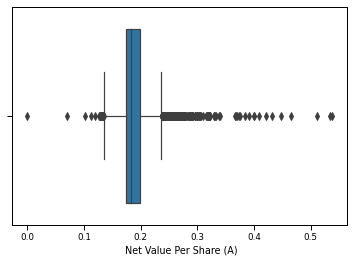

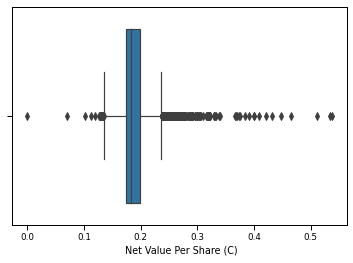

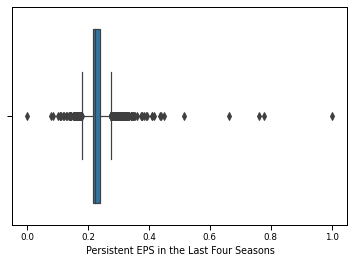

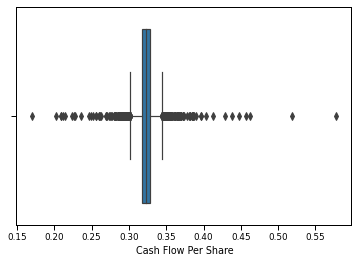

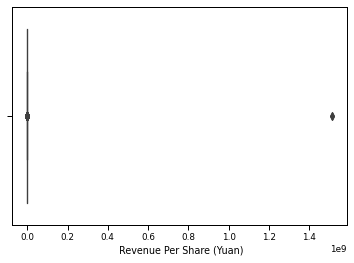

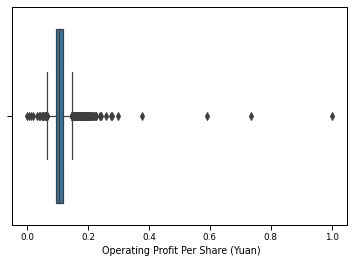

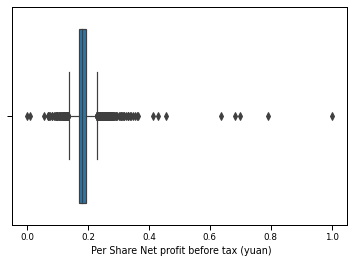

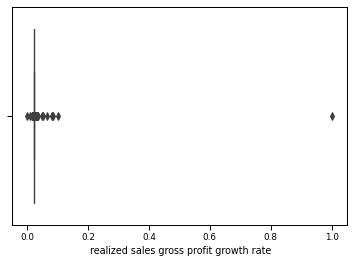

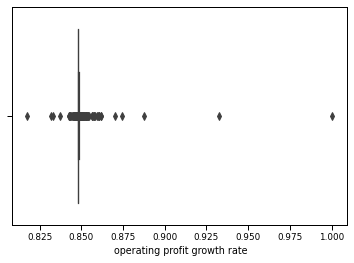

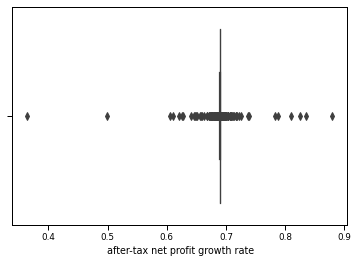

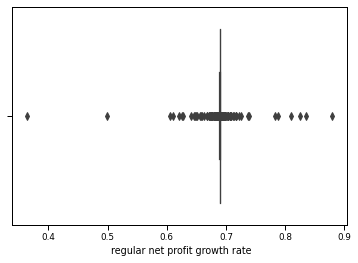

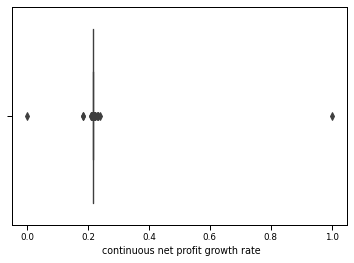

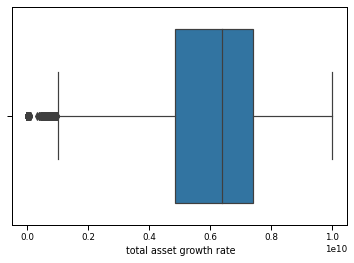

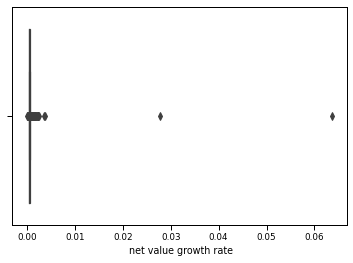

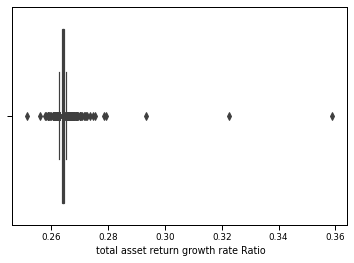

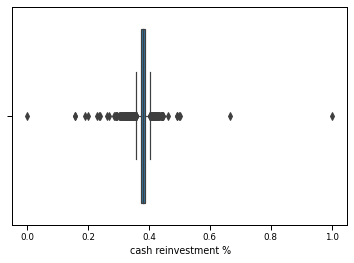

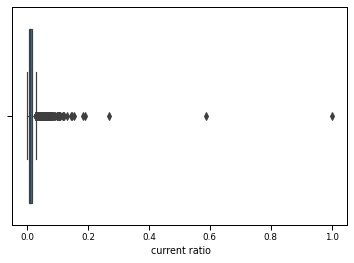

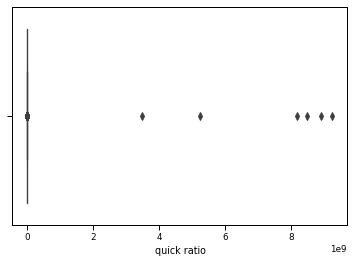

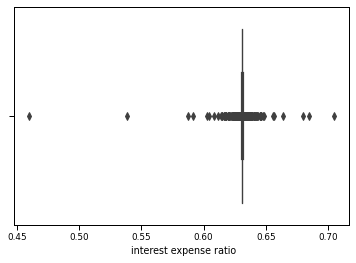

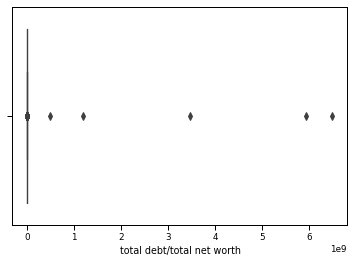

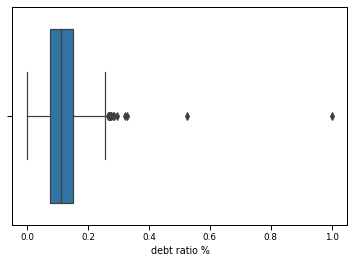

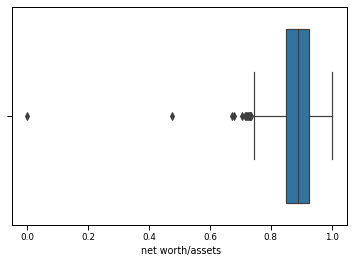

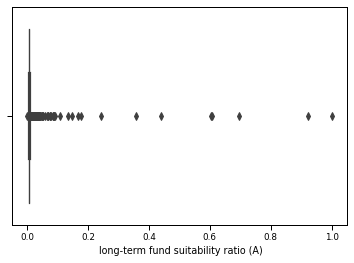

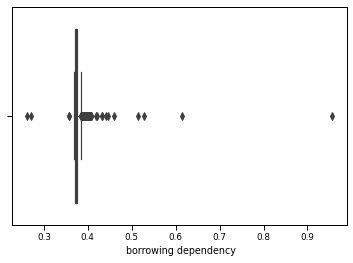

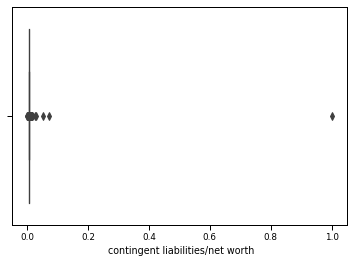

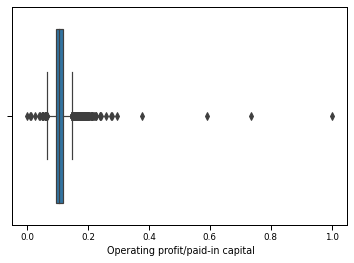

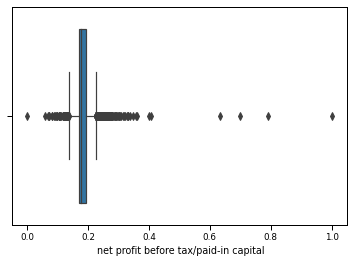

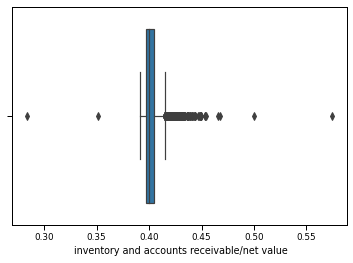

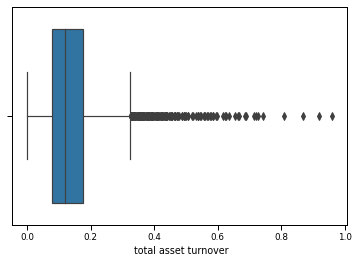

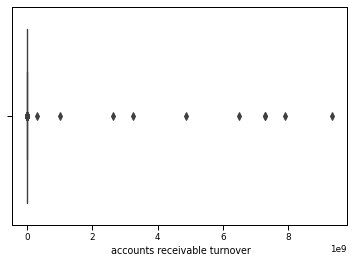

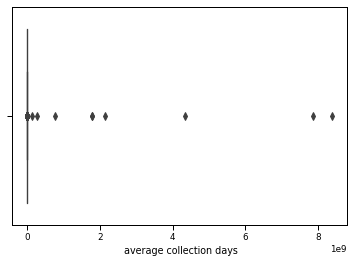

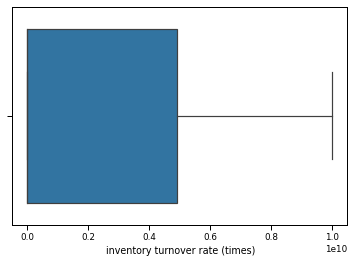

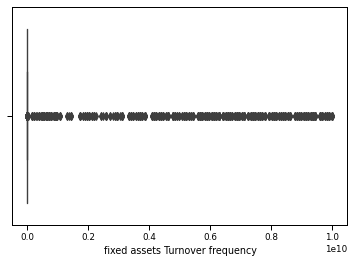

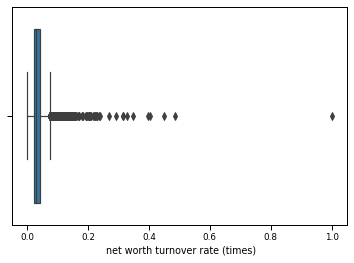

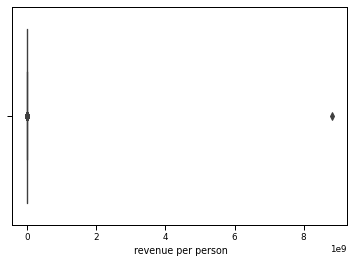

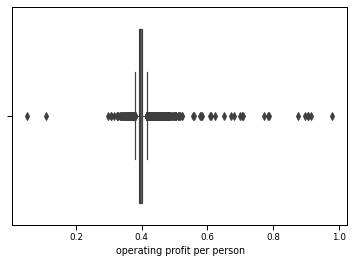

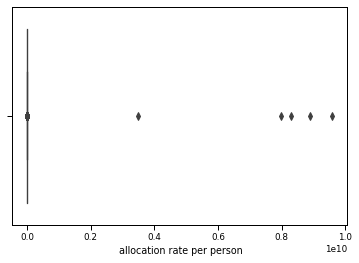

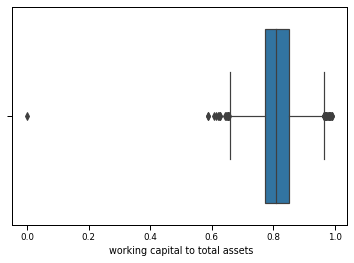

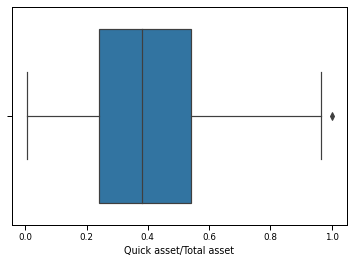

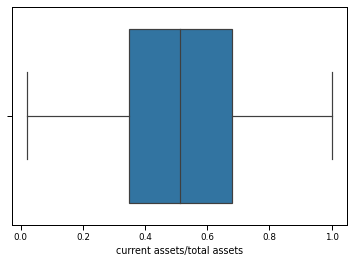

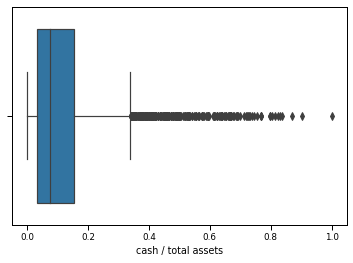

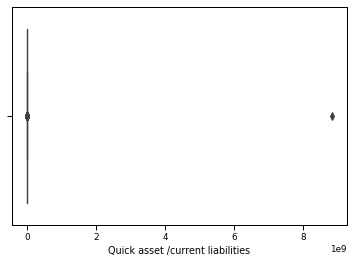

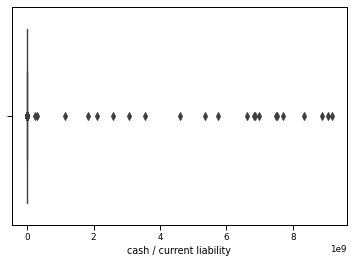

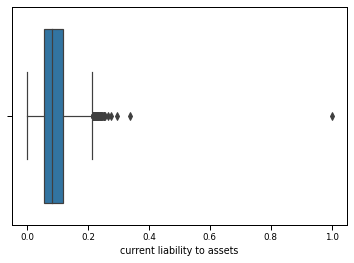

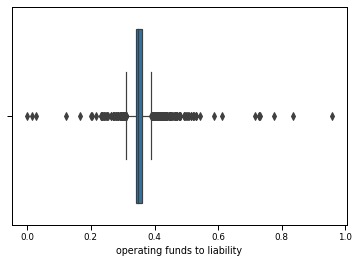

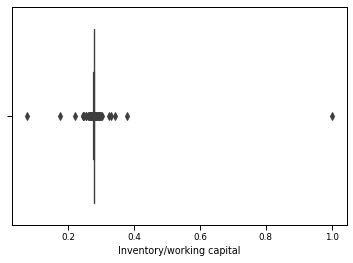

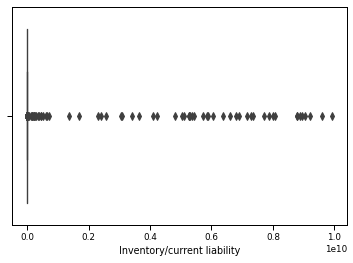

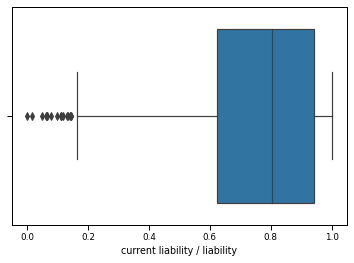

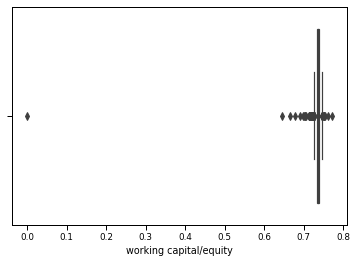

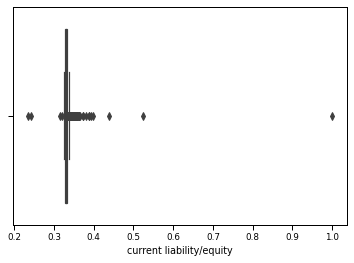

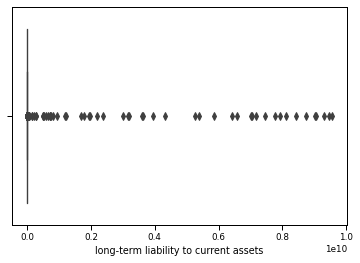

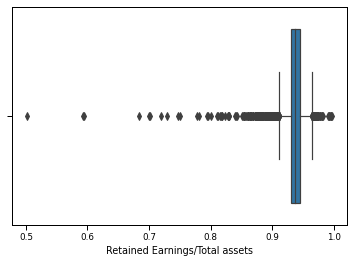

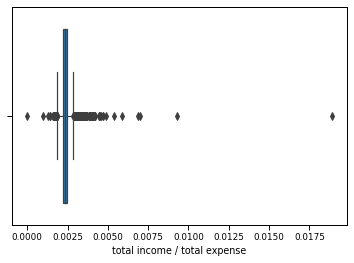

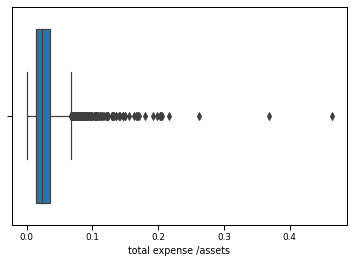

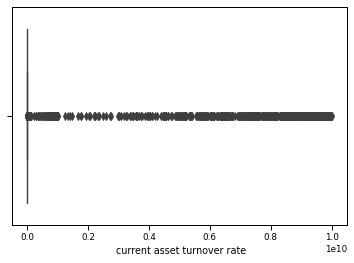

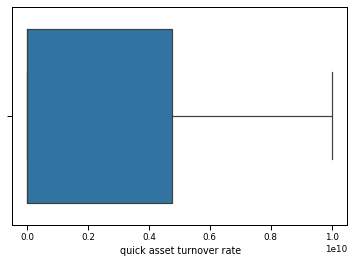

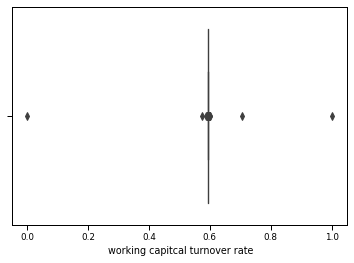

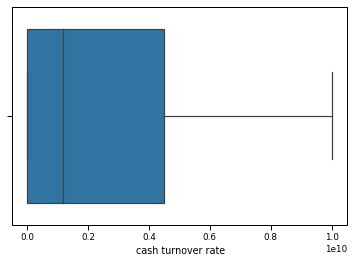

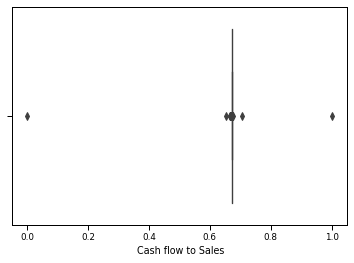

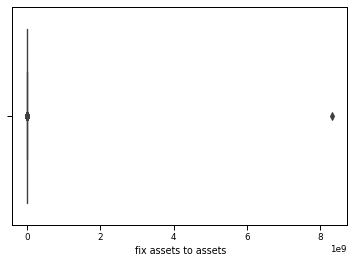

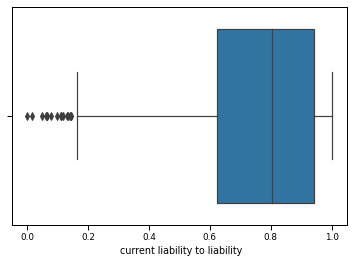

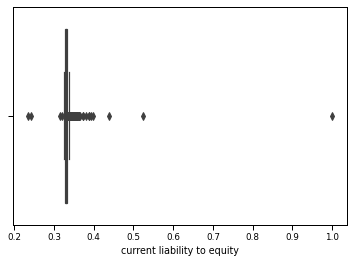

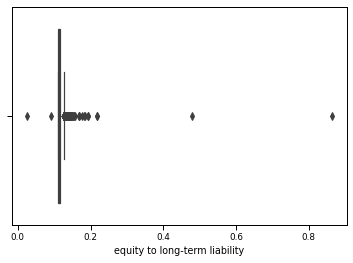

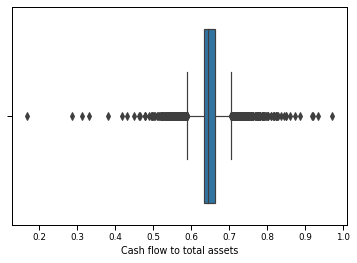

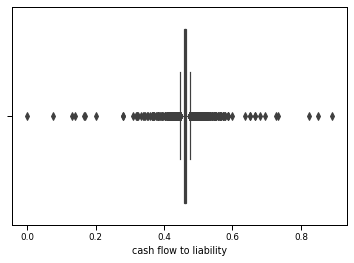

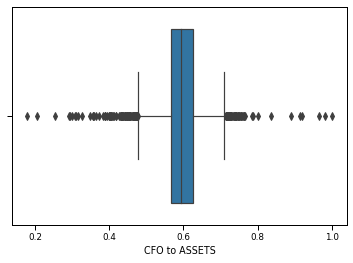

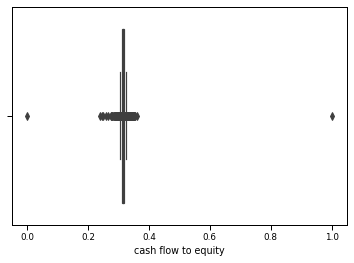

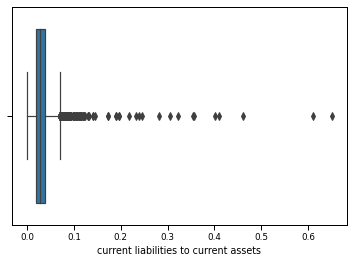

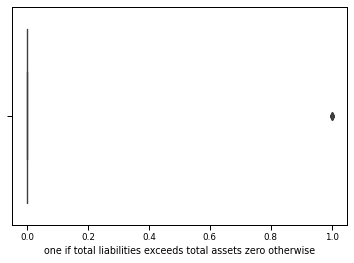

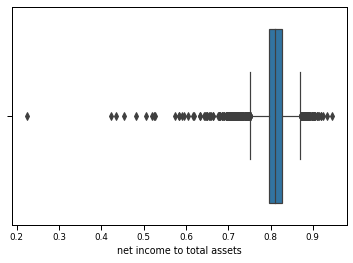

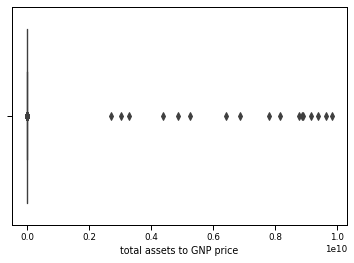

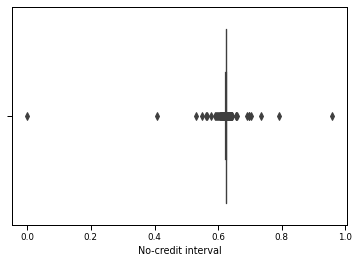

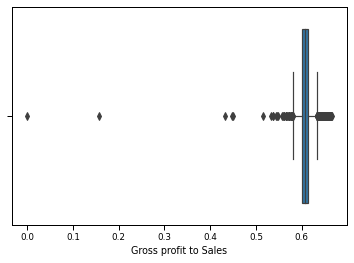

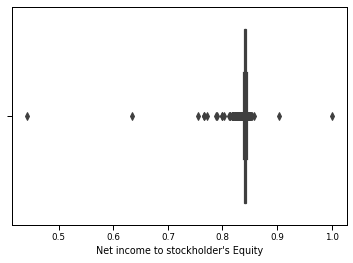

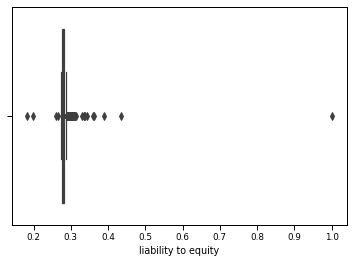

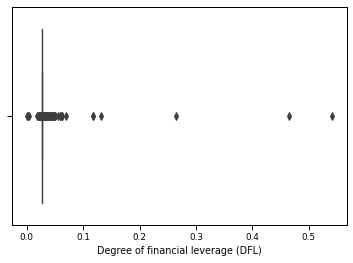

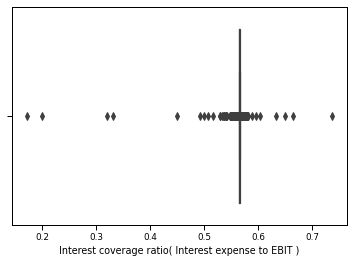

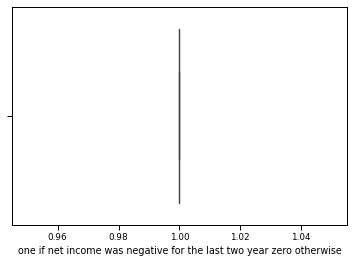

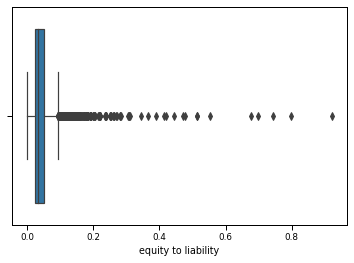

In [410]:
# Checking labels distributions

for column in bank_data:
    plt.figure()
    sns.boxplot(x=bank_data[column])

Looking at the plot above we can clearly see how our labels are strongly unbalanced, and this is a the main obstacle that we need to solve to obtain good performances.

In [411]:
#GETTING MORE INFO ABOUT THE DATA

X = bank_data.copy()
y = bank_data['Bankrupt']

print('Financially stable: ', round(bank_data['Bankrupt'].value_counts()[0]/len(bank_data) * 100,2), '% of the dataset')
print('Financially unstable: ', round(bank_data['Bankrupt'].value_counts()[1]/len(bank_data) * 100,2), '% of the dataset')
print('-'*45)

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    #print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 45)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Financially stable:  96.77 % of the dataset
Financially unstable:  3.23 % of the dataset
---------------------------------------------
---------------------------------------------
Label Distributions: 

[0.96774194 0.03225806]
[0.96774194 0.03225806]


In [412]:
# Lets shuffle the data before creating the subsamples

df = bank_data.sample(frac=1)

# amount of fraud classes 220 rows

unstable_df = df.loc[df['Bankrupt'] == 1]
stable_df = df.loc[df['Bankrupt'] == 0][:220]

normal_distributed_df = pd.concat([unstable_df, stable_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,id,Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
853,853,1,0.449276,0.490188,0.500669,0.599656,0.599648,0.998970,0.797176,0.809116,...,0.766320,0.001614,0.625687,0.599651,0.833757,0.298629,0.026524,0.563454,1,0.014274
838,838,0,0.517184,0.576156,0.565394,0.604016,0.603987,0.999029,0.797489,0.809391,...,0.818215,0.002109,0.623939,0.604011,0.841718,0.278927,0.026884,0.565565,1,0.033033
983,983,0,0.503632,0.557348,0.559398,0.605933,0.605579,0.999057,0.797536,0.809450,...,0.810189,0.016484,0.623203,0.605932,0.840877,0.276532,0.026840,0.565381,1,0.062537
710,710,1,0.411300,0.475469,0.456074,0.593688,0.593688,0.998872,0.797057,0.809027,...,0.749555,0.017571,0.622808,0.593690,0.830318,0.298268,0.026437,0.562615,1,0.014336
2485,2485,1,0.439624,0.485772,0.492371,0.594668,0.594668,0.998811,0.797196,0.809143,...,0.767479,0.000640,0.623623,0.594667,0.837440,0.281231,0.026719,0.564788,1,0.025012


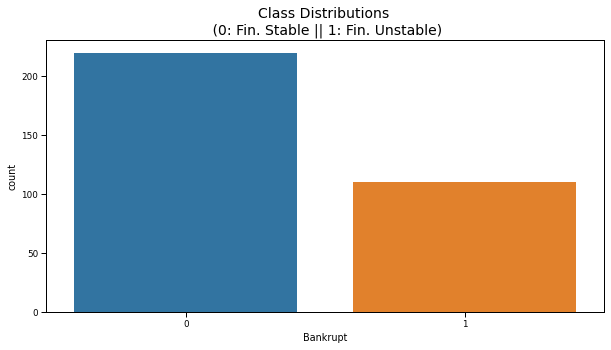

In [413]:
# Checking labels distributions
sns.set_context("paper")

plt.figure(figsize = (10,5))
sns.countplot(new_df['Bankrupt'])
plt.title('Class Distributions \n (0: Fin. Stable || 1: Fin. Unstable)', fontsize=14)
plt.show()

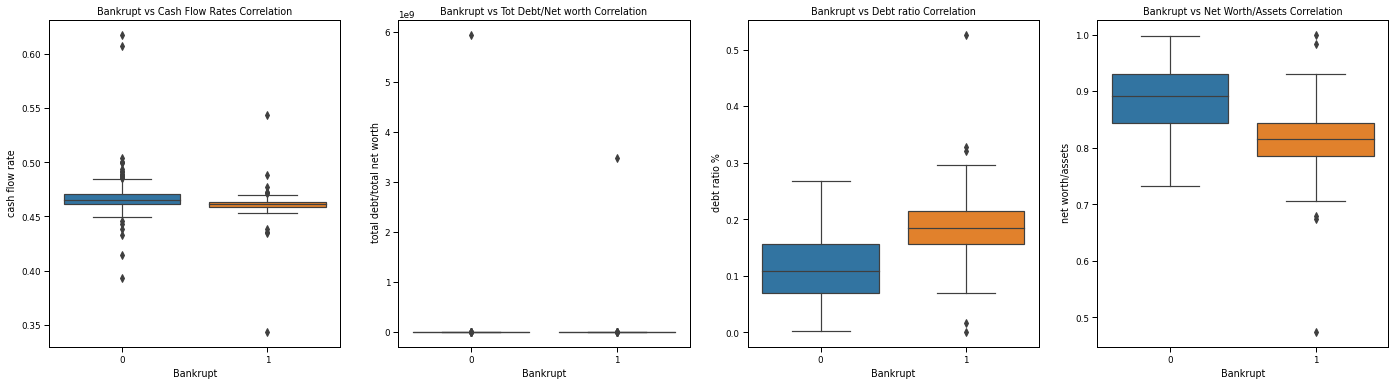

In [414]:
# Plotting features with an interesting correlation

f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt', y=" cash flow rate", data=new_df, ax=axes[0])
axes[0].set_title('Bankrupt vs Cash Flow Rates Correlation')

sns.boxplot(x='Bankrupt', y=" total debt/total net worth", data=new_df, ax=axes[1]) 
axes[1].set_title('Bankrupt vs Tot Debt/Net worth Correlation')


sns.boxplot(x='Bankrupt', y=" debt ratio %", data=new_df, ax=axes[2])
axes[2].set_title('Bankrupt vs Debt ratio Correlation')


sns.boxplot(x='Bankrupt', y=" net worth/assets", data=new_df, ax=axes[3])  
axes[3].set_title('Bankrupt vs Net Worth/Assets Correlation') 

plt.show()

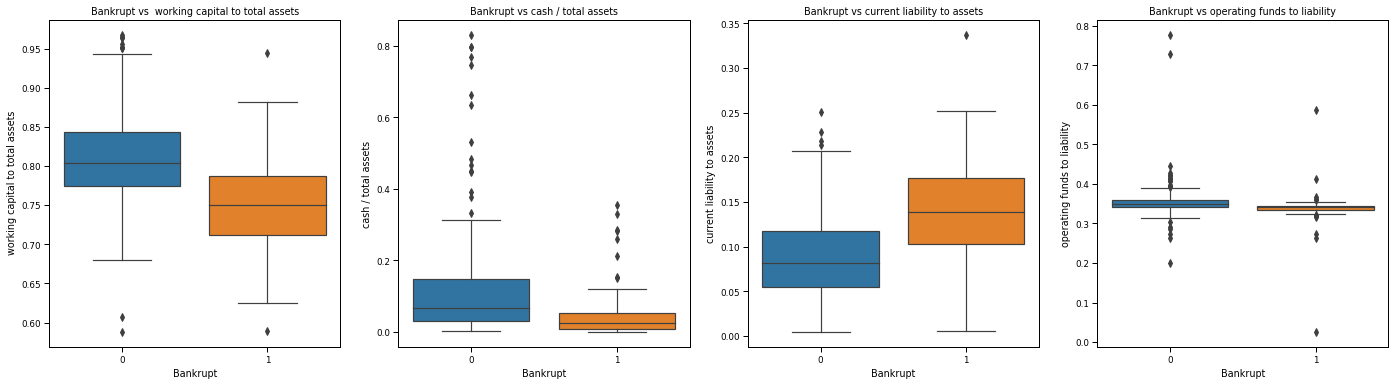

In [415]:
# Plotting other features with an interesting correlation

f, axes = plt.subplots(ncols=4, figsize=(24,6))

sns.boxplot(x='Bankrupt', y=" working capital to total assets", data=new_df, ax=axes[0])
axes[0].set_title('Bankrupt vs  working capital to total assets')

sns.boxplot(x='Bankrupt', y="cash / total assets", data=new_df, ax=axes[1])
axes[1].set_title('Bankrupt vs cash / total assets')


sns.boxplot(x='Bankrupt', y="current liability to assets", data=new_df, ax=axes[2])
axes[2].set_title('Bankrupt vs current liability to assets')


sns.boxplot(x='Bankrupt', y="operating funds to liability", data=new_df, ax=axes[3])
axes[3].set_title('Bankrupt vs operating funds to liability')

plt.show()

Now, let's look at the distribution of these features for companies that are close to bankruptcy:

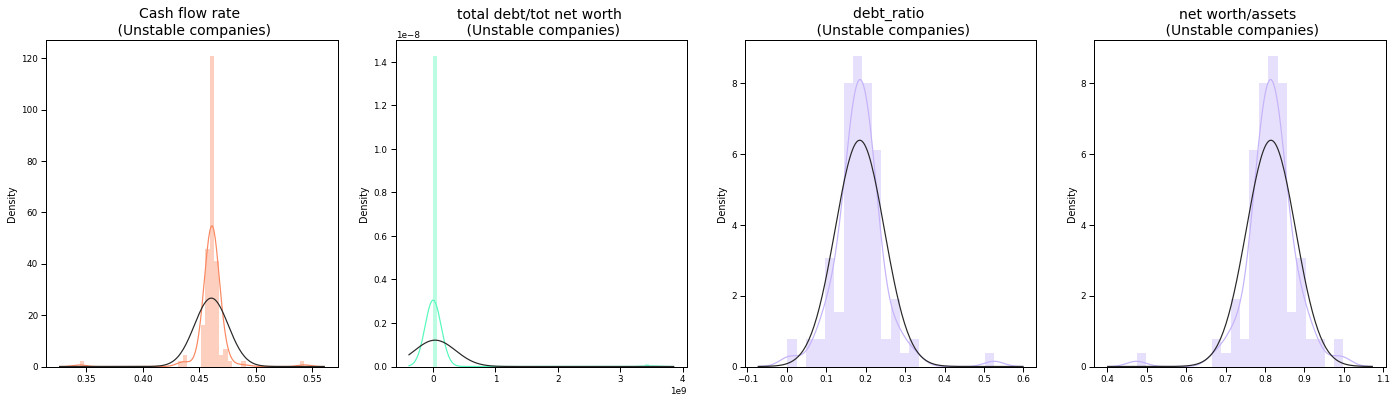

In [416]:
# Plotting the feature distributions for close to bankrputcy companies

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = new_df[' cash flow rate'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Cash flow rate \n (Unstable companies)', fontsize=14)

tot_debt_net = new_df[' total debt/total net worth'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = new_df[' debt ratio %'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = new_df[' net worth/assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

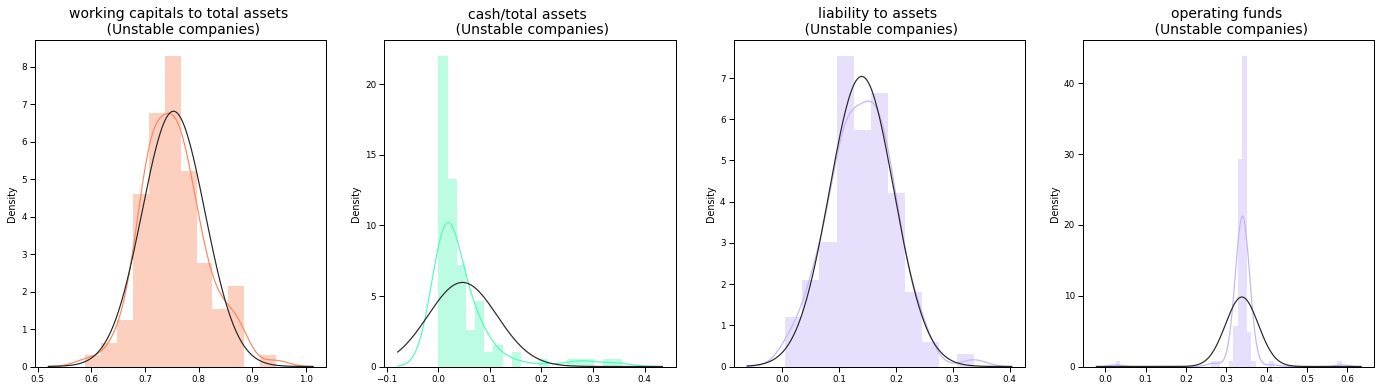

In [417]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = new_df[' working capital to total assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = new_df['cash / total assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)


asset_liab = new_df['current liability to assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = new_df['operating funds to liability'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('operating funds \n (Unstable companies)', fontsize=14)

plt.show()

Outliers removal

In this part of the project will try to remove the most extreme outliers (note that you can also impute them with the mean or the median instead of removing them). This should increase our models' performance.

In [418]:
# Outliers removal function

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

new_df = outliers_removal(new_df[' cash flow rate'],' cash flow rate', new_df)
new_df = outliers_removal(new_df[' total debt/total net worth'],' total debt/total net worth', new_df)
new_df = outliers_removal(new_df[' debt ratio %'],' debt ratio %', new_df)
new_df = outliers_removal(new_df[' net worth/assets'],' net worth/assets', new_df)
new_df = outliers_removal(new_df[' working capital to total assets'],' working capital to total assets', new_df)
new_df = outliers_removal(new_df['cash / total assets'],'cash / total assets', new_df)
new_df = outliers_removal(new_df['current liability to assets'],'current liability to assets', new_df)
new_df = outliers_removal(new_df['operating funds to liability'],'operating funds to liability', new_df)

Quartile 25: 0.46024928075958516 | Quartile 75: 0.468327839426956
iqr: 0.008078558667370839
Cut Off: 0.012117838001056258
 cash flow rate Lower: 0.4481314427585289
 cash flow rate Upper: 0.48044567742801225
 cash flow rate outliers for close to bankruptcy cases: 32
-----------------------------------------------------------------
Quartile 25: 0.0045666566355702 | Quartile 75: 0.01521808515488925
iqr: 0.01065142851931905
Cut Off: 0.015977142778978576
 total debt/total net worth Lower: -0.011410486143408376
 total debt/total net worth Upper: 0.031195227933867826
 total debt/total net worth outliers for close to bankruptcy cases: 18
-----------------------------------------------------------------
Quartile 25: 0.09598059074281223 | Quartile 75: 0.180268766816821
iqr: 0.08428817607400876
Cut Off: 0.12643226411101316
 debt ratio % Lower: -0.030451673368200927
 debt ratio % Upper: 0.3067010309278342
 debt ratio % outliers for close to bankruptcy cases: 1
-------------------------------------

Now, let's look at the cleaned boxplots:

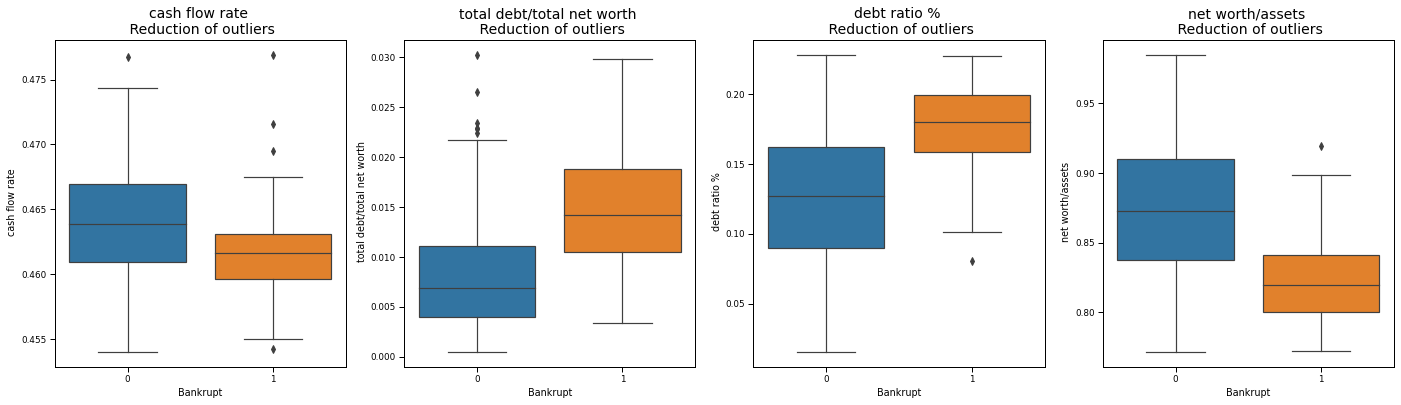

In [419]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

# Boxplots with outliers removed

sns.boxplot(x="Bankrupt", y=" cash flow rate", data=new_df,ax=ax1) 
ax1.set_title("cash flow rate \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt", y=" total debt/total net worth", data=new_df,ax=ax2) 
ax2.set_title("total debt/total net worth \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt", y=" debt ratio %", data=new_df,ax=ax3) 
ax3.set_title("debt ratio % \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt", y=' net worth/assets', data=new_df,ax=ax4) 
ax4.set_title("net worth/assets \n Reduction of outliers", fontsize=14)
        
plt.show()

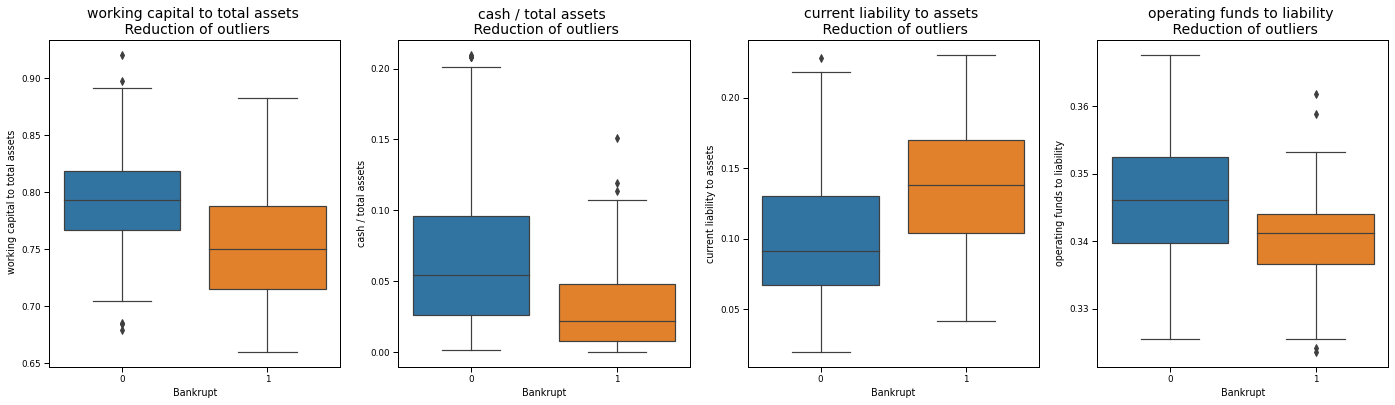

In [420]:
f,(ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24,6))

# Boxplots with outliers removed

sns.boxplot(x="Bankrupt", y=' working capital to total assets', data=new_df,ax=ax1) 
ax1.set_title("working capital to total assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt", y='cash / total assets', data=new_df,ax=ax2) 
ax2.set_title("cash / total assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt", y='current liability to assets', data=new_df,ax=ax3) 
ax3.set_title("current liability to assets \n Reduction of outliers", fontsize=14)

sns.boxplot(x="Bankrupt", y='operating funds to liability', data=new_df,ax=ax4) 
ax4.set_title("operating funds to liability \n Reduction of outliers", fontsize=14)
        
plt.show()

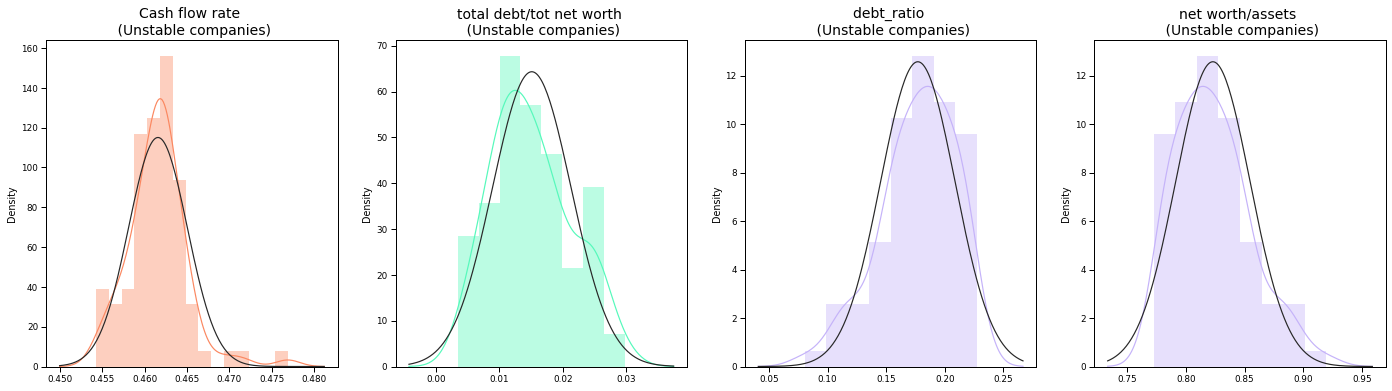

In [421]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

cash_flow_rate = new_df[' cash flow rate'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(cash_flow_rate,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Cash flow rate \n (Unstable companies)', fontsize=14)

tot_debt_net = new_df[' total debt/total net worth'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(tot_debt_net ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('total debt/tot net worth \n (Unstable companies)', fontsize=14)


debt_ratio = new_df[' debt ratio %'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(debt_ratio,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('debt_ratio \n (Unstable companies)', fontsize=14)

net_worth_assets = new_df[' net worth/assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(net_worth_assets,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('net worth/assets \n (Unstable companies)', fontsize=14)

plt.show()

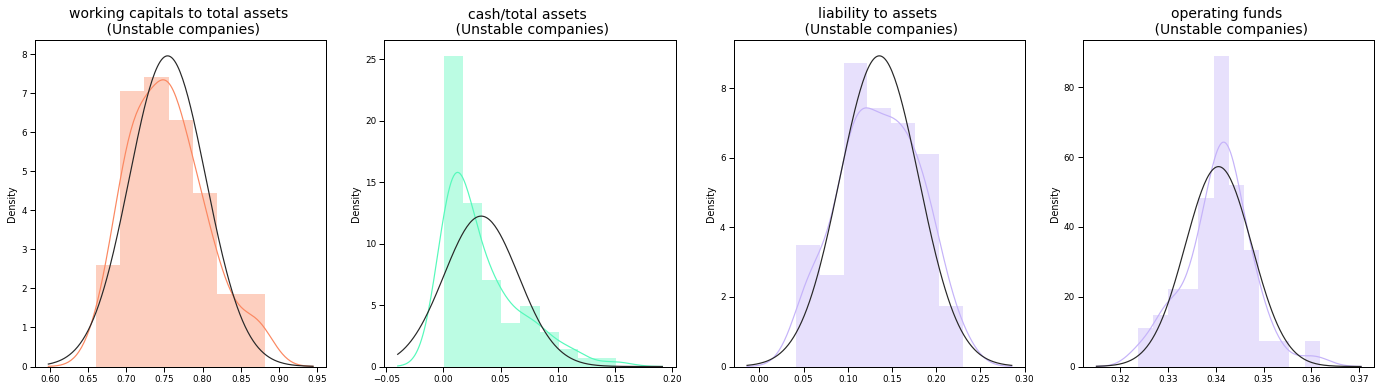

In [422]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 6))

working_cap = new_df[' working capital to total assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(working_cap,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('working capitals to total assets \n (Unstable companies)', fontsize=14)

cash_tot_assets = new_df['cash / total assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(cash_tot_assets ,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('cash/total assets \n (Unstable companies)', fontsize=14)


asset_liab = new_df['current liability to assets'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(asset_liab,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('liability to assets \n (Unstable companies)', fontsize=14)

operating_funds = new_df['operating funds to liability'].loc[new_df['Bankrupt'] == 1].values
sns.distplot(operating_funds,ax=ax4, fit=norm, color='#C5B3F9')
ax4.set_title('operating funds \n (Unstable companies)', fontsize=14)

plt.show()

What we can see is that removing the extreme outliers definitely helps to obtain more "bell shape" distributions!

MODELING

I will start modeling the predictions

In [423]:
#DROPPING VALUES
X = bank_data.drop(['Bankrupt'],axis = 1).values
y = bank_data['Bankrupt'].values
y = y.reshape(-1, 1)

# Transforming the dataset
X_train,X_val,y_train,y_val = train_test_split(X, y, test_size = 0.33,random_state = 342)



In [424]:
#DECISION TREE
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
y_pred = decisiontree.predict(X_val)

# Classification Report
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print("Decision Tree Accuracy:")
print(classification_report(y_val, y_pred))

Decision Tree Accuracy:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1093
           1       0.22      0.27      0.24        33

    accuracy                           0.95      1126
   macro avg       0.60      0.62      0.61      1126
weighted avg       0.96      0.95      0.95      1126



In [425]:
# RANDOM FOREST
test_data = test_data.values
randomForest = RandomForestClassifier(n_estimators=200, min_samples_split=20, min_samples_leaf=12, max_depth=40, max_features='sqrt',  bootstrap=False)
randomForest.fit(X_train, y_train)
y_pred = randomForest.predict_proba(X_val)[:,1]

# Classification Report
acc_randomforest = round(accuracy_score(y_val, y_pred.round()) * 100, 2)
print("Probability Algorithm Accuracy:")
print(classification_report(y_val, y_pred.round()))

Probability Algorithm Accuracy:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1093
           1       0.62      0.15      0.24        33

    accuracy                           0.97      1126
   macro avg       0.80      0.57      0.61      1126
weighted avg       0.96      0.97      0.96      1126



In [426]:
#GENERATING SCORE OVERVIEW OF ALL ALGORITHM PERFORMANCES
models = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Score': [acc_decisiontree, acc_randomforest]})
models.sort_values(by='Score', ascending=True)

,Model,Score
0,Decision Tree,95.03
1,Random Forest,97.25


Comparing the results with the one obtained using undersampling, we can see how the difference is between using random Forest and Decision Tree Algorithm. This achieves an almost perfect performance, and not just in terms of accuracy, but also in all the other metrics: precision, recall, and F1_score. We created an incredible model, and with basically no effort

In [427]:
#TAKING A LOOK AT THE SAMPLE DATA
sample_data

,id,Bankrupt
0,0,0.84
1,1,0.74
2,2,0.40
3,3,0.37
4,4,0.88
...,...,...
3404,3404,0.49
3405,3405,0.51
3406,3406,0.60
3407,3407,0.48


Since, I can see that Proba Algorithm provides me with a desired output and it provides with a close approach to what I am looking for. I have enough evidence to conclude that I Proba is the best Machine Learning Algorithm to attack this prediction

In [432]:
#MAKING CSV FILE USING RAINFOREST PROBA ALGORITHM

y_pred = randomForest.predict_proba(test_data)[:,1]
output = pd.DataFrame({'id': np.arange(0,3409), 'Bankrupt': y_pred})
output['Bankrupt'] = y_pred
output.to_csv("submission.csv")

#TAKING A LOOK AT THE FINAL ANSWER HEAD
output

,Bankrupt
id,
0,0.010183
1,0.002500
2,0.016837
3,0.008026
4,0.000000
...,...
3404,0.002132
3405,0.000000
3406,0.001083
